## Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras import layers, optimizers, datasets
from keras_preprocessing.image import ImageDataGenerator

import os
import cv2
from sklearn import preprocessing
from pathlib import Path
import splitfolders

import shutil

### Membuat data Validation dari 20% data train

In [2]:
srcPath = 'fingers/train/' 
destPath = 'fingers/validation/' 
files = os.listdir(srcPath)

for file in files[:3600]:
    shutil.move(srcPath + file, destPath + file)

## Augmentasi

### Menyimpan dataset yang akan digunakan

In [3]:
train = os.listdir('fingers/train/')
test = os.listdir('fingers/test/')
val = os.listdir('fingers/validation/')

all_train = ['fingers/train/' + i for i in train]
all_test = ['fingers/test/' + i for i in test]
all_val = ['fingers/validation/' + i for i in val]

In [4]:
train_df = pd.DataFrame(all_train, columns=['Filepath'])
test_df = pd.DataFrame(all_test, columns=['Filepath'])
val_df = pd.DataFrame(all_val, columns=['Filepath'])

train_df.head()

,Filepath
0,fingers/train/7f189a03-586a-4e35-8f9f-78e35641...
1,fingers/train/7f194657-b7d8-463c-aa11-a70c5810...
2,fingers/train/7f1a0afd-f3d5-41ad-a8fd-e434fdf9...
3,fingers/train/7f1b7567-68c3-4243-aaa9-c8da38d6...
4,fingers/train/7f21257d-3100-4970-9170-990db02c...


In [5]:
train_df['Label'] = train_df['Filepath'].apply(lambda a: a[-6:-4])
test_df['Label'] = test_df['Filepath'].apply(lambda a: a[-6:-4])
val_df['Label'] = val_df['Filepath'].apply(lambda a: a[-6:-4])

train_df.head()

,Filepath,Label
0,fingers/train/7f189a03-586a-4e35-8f9f-78e35641...,0L
1,fingers/train/7f194657-b7d8-463c-aa11-a70c5810...,1L
2,fingers/train/7f1a0afd-f3d5-41ad-a8fd-e434fdf9...,3L
3,fingers/train/7f1b7567-68c3-4243-aaa9-c8da38d6...,3L
4,fingers/train/7f21257d-3100-4970-9170-990db02c...,5L


### Membuat datagen untuk mendeklarasikan ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=.2,
    zoom_range=.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

### Kemudian ambil dataset melalui datagen yang telah dibuat

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(50, 50),
    shuffle=True,
    batch_size=4,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(50, 50),
    shuffle=True,
    batch_size=2,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(50, 50),
    shuffle=True,
    batch_size=2,
    class_mode='categorical'
)

Found 9000 validated image filenames belonging to 12 classes.
Found 1800 validated image filenames belonging to 12 classes.
Found 10800 validated image filenames belonging to 12 classes.


In [8]:
image, label = train_generator.next()

In [10]:
image

array([[[[0.16716179, 0.16716179, 0.16716179],
         [0.16558635, 0.16558635, 0.16558635],
         [0.18633206, 0.18633206, 0.18633206],
         ...,
         [0.23289137, 0.23289137, 0.23289137],
         [0.2343573 , 0.2343573 , 0.2343573 ],
         [0.23423594, 0.23423594, 0.23423594]],

        [[0.17164256, 0.17164256, 0.17164256],
         [0.16183671, 0.16183671, 0.16183671],
         [0.17889902, 0.17889902, 0.17889902],
         ...,
         [0.23174915, 0.23174915, 0.23174915],
         [0.22881727, 0.22881727, 0.22881727],
         [0.22040588, 0.22040588, 0.22040588]],

        [[0.17758898, 0.17758898, 0.17758898],
         [0.16480994, 0.16480994, 0.16480994],
         [0.171466  , 0.171466  , 0.171466  ],
         ...,
         [0.20921522, 0.20921522, 0.20921522],
         [0.19602185, 0.19602185, 0.19602185],
         [0.19422986, 0.19422986, 0.19422986]],

        ...,

        [[0.1809887 , 0.1809887 , 0.1809887 ],
         [0.18704902, 0.18704902, 0.18704902]

In [11]:
label

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Reading Data 

In [9]:
# Membaca Data Train Gambar
train_path = []
label_train = []

path_train = "fingers/train/"

for filename in os.listdir(path_train):
    
    train_path.append(path_train+filename)
    whole_label = filename.split('_')[1]
    useful_label = whole_label.split('.')[0]
    label_train.append(useful_label)

print("Jumlah Gambar Data Train: ", len(train_path))
print("6 Label Pertama: ", label_train[:6])

Jumlah Gambar Data Train:  9000
6 Label Pertama:  ['0L', '1L', '3L', '3L', '5L', '3L']


In [10]:
# Membaca Data Test Gambar 
test_path = []
label_test = []

path_test = "fingers/test/"

for filename in os.listdir(path_test):
    
    test_path.append(path_test+filename)
    whole_label = filename.split('_')[1]
    useful_label = whole_label.split('.')[0]
    label_test.append(useful_label)

print("Jumlah Gambar Data Test: ", len(test_path))
print("6 Label Pertama: ", label_test[:6])

Jumlah Gambar Data Test:  1800
6 Label Pertama:  ['2R', '4R', '3L', '1R', '5L', '4L']


In [11]:
# Membaca Data Validation Gambar 
val_path = []
label_val = []

path_val = "fingers/validation/"

for filename in os.listdir(path_val):
    
    val_path.append(path_val+filename)
    whole_label = filename.split('_')[1]
    useful_label = whole_label.split('.')[0]
    label_val.append(useful_label)

print("Jumlah Gambar Data Validation: ", len(val_path))
print("6 Label Pertama: ", label_val[:6])

Jumlah Gambar Data Validation:  10800
6 Label Pertama:  ['0L', '0L', '2L', '0L', '5L', '5L']


### Visualisasi Data Gambar 

In [15]:
train_path[0]

'fingers/train/2956811a-7483-4ff6-8cc0-535297d7aefe_1L.png'

### Memeriksa gambar pertama milik folder data train yg di clean 

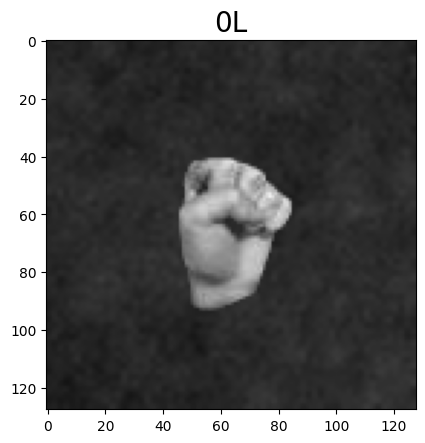

In [12]:
image = cv2.imread(train_path[0]) 

plt.imshow(image)
plt.title(label_train[0], fontsize = 20)
plt.axis('on')
plt.show()

### Memeriksa gambar milik folder data test

In [13]:
test_path[100]

'fingers/test/87bdc42d-9525-4582-b579-187c0da9491b_3L.png'

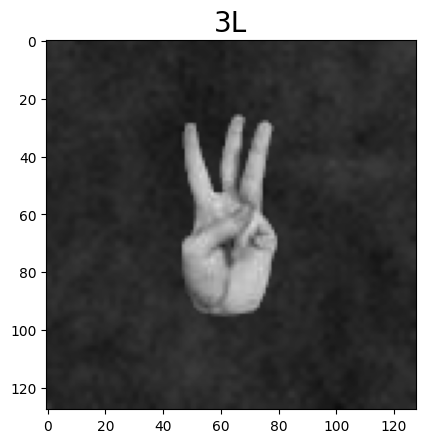

In [14]:
image = cv2.imread(test_path[100]) 

plt.imshow(image)
plt.title(label_test[100], fontsize = 20)
plt.axis('on')
plt.show()

### Contoh gambar milik data validation

In [15]:
val_path[200]

'fingers/validation/0236c944-6677-42c0-b9c2-c9bf7b267bec_0R.png'

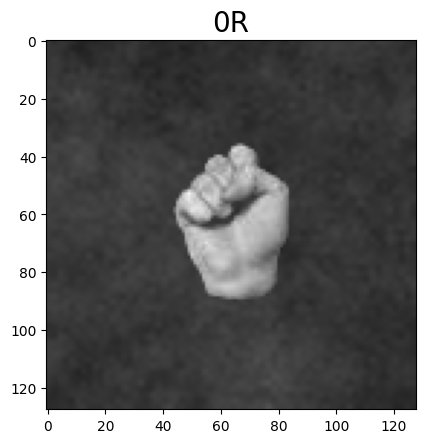

In [16]:
image = cv2.imread(val_path[200]) 

plt.imshow(image)
plt.title(label_val[200], fontsize = 20)
plt.axis('on')
plt.show()

## Data Preprocessing

### Membuat Data Train, Test, dan Validation

In [19]:
X_train = []
X_test = []
X_val = []

# membaca data gambar train data
for path in train_path:
    
    image = cv2.imread(path)        
    image =  cv2.resize(image, (50,50))    
    X_train.append(image)
    
# membaca data gambar test data
for path in test_path:
    
    image = cv2.imread(path)        
    image =  cv2.resize(image, (50,50))    
    X_test.append(image)
    
# membaca data gambar val data
for path in val_path:
    
    image = cv2.imread(path)        
    image =  cv2.resize(image, (50,50))    
    X_val.append(image)


X_test = np.array(X_test)
X_train = np.array(X_train)
X_val = np.array(X_val)

### Menampilkan dimensi data

In [20]:
print("Bentuk X_train: ", X_train.shape)
print("Bentuk X_test: ", X_test.shape)
print("Bentuk X_val: ", X_val.shape)

Bentuk X_train:  (9000, 50, 50, 3)
Bentuk X_test:  (1800, 50, 50, 3)
Bentuk X_val:  (10800, 50, 50, 3)


In [21]:
# Encoding Label dan menkonversi ke nilai kategorikal
lable_encoder = preprocessing.LabelEncoder()
y_train_temp = lable_encoder.fit_transform(label_train)
y_test_temp = lable_encoder.fit_transform(label_test)
y_val_temp = lable_encoder.fit_transform(label_val)


print("Nilai Encoding train: ", y_train_temp)
print("Nilai Encoding test: ", y_test_temp)
print("Nilai Encoding val: ", y_val_temp)

Nilai Encoding train:  [0 2 6 ... 1 4 4]
Nilai Encoding test:  [5 9 6 ... 9 7 7]
Nilai Encoding val:  [ 0  0  4 ...  9  5 10]


In [22]:
# Encoding data menggunakan keras utils
y_train = keras.utils.to_categorical(y_train_temp, 12)
y_test = keras.utils.to_categorical(y_test_temp, 12)
y_val = keras.utils.to_categorical(y_val_temp, 12)


print("Nilai Categorical y_train:", y_train,"\n")
print("Nilia Ctegorical  y_test:", y_test, "\n")
print("Nilia Ctegorical  y_val:", y_val, "\n")

Nilai Categorical y_train: [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Nilia Ctegorical  y_test: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Nilia Ctegorical  y_val: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]] 



### Visualisasi Data Sample

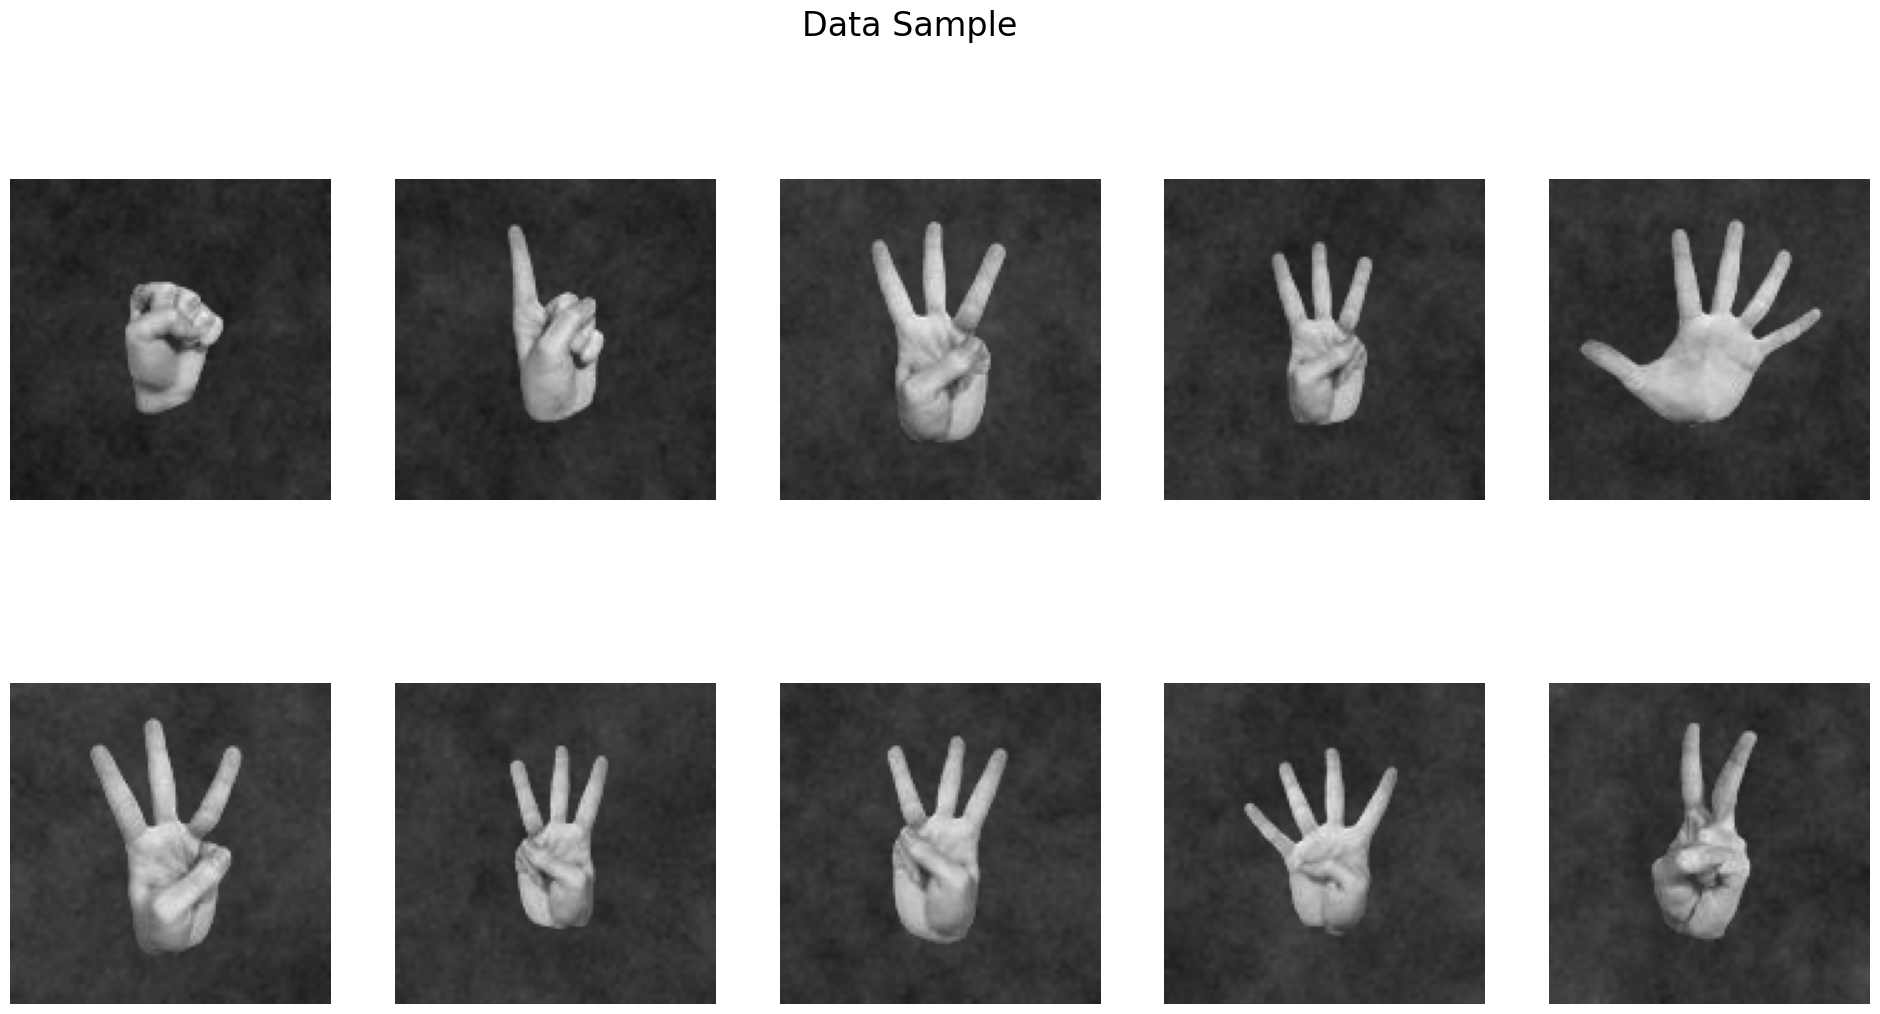

In [23]:
fig, axs= plt.subplots(2,5, figsize=[24,12])

count=0
for i in range(2):    
    for j in range(5):  
        
        img = cv2.imread(train_path[count])
    
        axs[i][j].imshow(img)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("Data Sample", fontsize = 24)        
plt.show()

### Membuat Sequential Model

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', input_shape=(50, 50, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(12, activation='softmax')
])

### Mengcompile model

In [25]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

In [26]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience=5,
)

In [104]:
history = model.fit(
    train_generator,
    # batch_size=128,
    epochs=10,
    # shuffle=True,
    validation_data=val_generator,
    verbose =1,
    callbacks=[earlyStopping]
    # (X_val, y_val)
)

Epoch 1/10
4050/4050 [==============================] - 221s 54ms/step - loss: 0.2148 - accuracy: 0.9269 - val_loss: 0.0232 - val_accuracy: 0.9917
Epoch 2/10
4050/4050 [==============================] - 212s 52ms/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.0044 - val_accuracy: 0.9983
Epoch 3/10
4050/4050 [==============================] - 214s 53ms/step - loss: 0.0299 - accuracy: 0.9916 - val_loss: 3.5090e-04 - val_accuracy: 1.0000
Epoch 4/10
4050/4050 [==============================] - 217s 53ms/step - loss: 0.0293 - accuracy: 0.9928 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 5/10
4050/4050 [==============================] - 221s 55ms/step - loss: 0.0211 - accuracy: 0.9943 - val_loss: 0.0012 - val_accuracy: 0.9994
Epoch 6/10
4050/4050 [==============================] - 214s 53ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 7.2626e-04 - val_accuracy: 1.0000
Epoch 7/10
4050/4050 [==============================] - 217s 54ms/step - loss: 0.0121 - accuracy: 0.9968 - val

In [31]:
y_acc_train = history.history['accuracy']
y_acc_val = history.history['val_accuracy']


y_loss_train =history.history['loss']
y_loss_val =history.history['val_loss']

x_=range(len(y_acc_train))

NameError: name 'history' is not defined

In [32]:
plt.figure(1, figsize=(5,4))
plt.plot(x_, y_acc_train, c='r',label='Training')
plt.plot(x_, y_acc_val, c='b',label='Validation')
plt.title('akurasi')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()


plt.figure(2, figsize=(5,4))
plt.plot(x_[5:], y_loss_train[5:], c='r',label='Training')
plt.plot(x_[5:], y_loss_val[5:], c='b',label='Validation')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

NameError: name 'x_' is not defined

<Figure size 500x400 with 0 Axes>

In [33]:
model.evaluate(test_generator)

900/900 [==============================] - 18s 20ms/step - loss: 2.4910 - accuracy: 0.0883


[2.491011381149292, 0.08833333104848862]

In [34]:
pred = model.predict(X_test)
print(pred)

57/57 [==============================] - 12s 213ms/step
[[0.08878473 0.08027484 0.08406709 ... 0.08422908 0.07905737 0.07438105]
 [0.08928862 0.07721814 0.08525978 ... 0.08345844 0.07657953 0.07340946]
 [0.08737144 0.07814877 0.08427721 ... 0.08637509 0.07895182 0.07284813]
 ...
 [0.09015793 0.07735378 0.08432158 ... 0.08517572 0.07636246 0.07237526]
 [0.09017484 0.07757767 0.08401348 ... 0.08403067 0.07701521 0.07327236]
 [0.08983219 0.0782932  0.08491399 ... 0.08444353 0.07514355 0.07217914]]


In [42]:
model.save('D:\semester 5\Praktikum KB\PA_KB\PA_KB_3_A1')

INFO:tensorflow:Assets written to: D:\semester 5\Praktikum KB\PA_KB\PA_KB_3_A1\assets


INFO:tensorflow:Assets written to: D:\semester 5\Praktikum KB\PA_KB\PA_KB_3_A1\assets


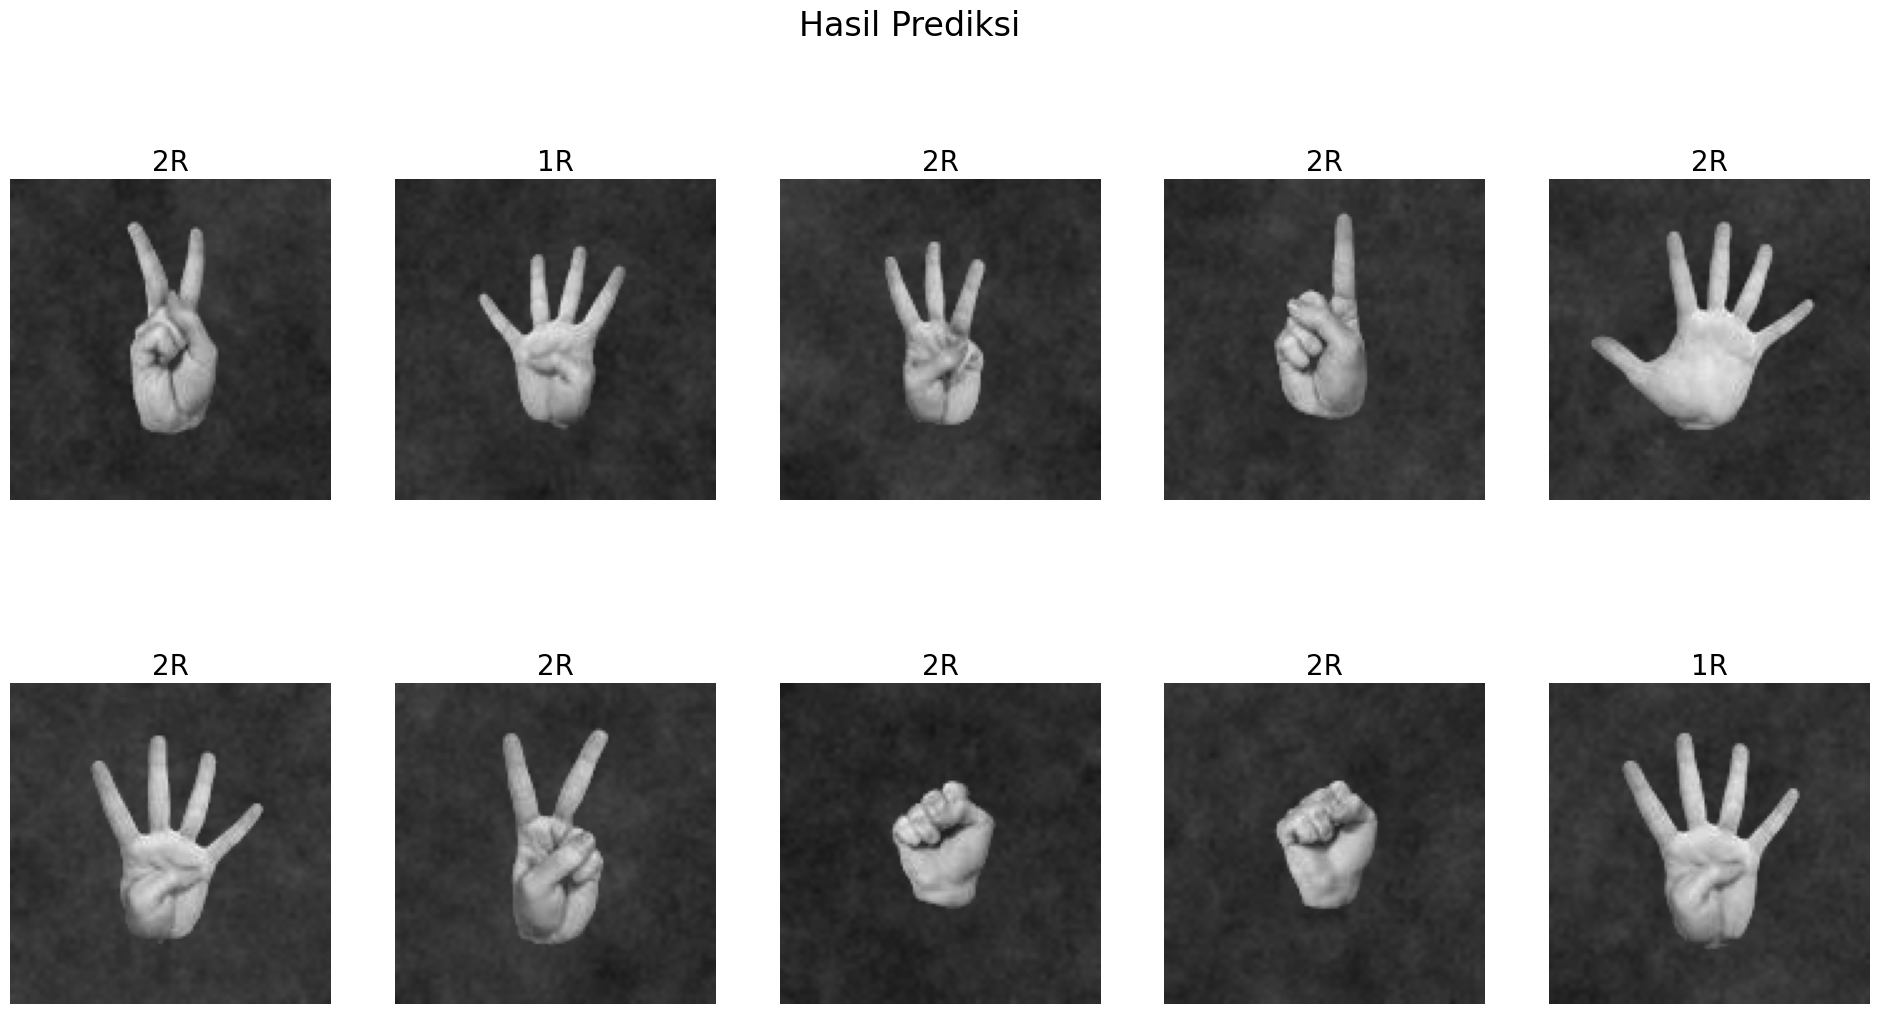

In [43]:
fig, axs= plt.subplots(2,5, figsize=[24,12])


count=0
for i in range(2):    
    for j in range(5):  
        
        img = cv2.imread(test_path[count])
        
        results = np.argsort(pred[count])[::-1]
      
        labels = lable_encoder.inverse_transform(results)
        
        axs[i][j].imshow(img)
        axs[i][j].set_title(labels[0], fontsize = 20)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("Hasil Prediksi", fontsize = 24)        
plt.show()